In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import os
import torchio as tio
from options.test_options import TestOptions
import numpy as np
from models.models import create_model
from util.visualizer import Visualizer
from util import html
import torch
#from models.networks import Dense3DSpatialTransformer
from medipy.metrics import dice
import torch.nn.functional as F
import nrrd
import nibabel as nib
from scipy.ndimage import zoom
#%matplotlib widget

In [2]:
class Params(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __getstate__(self):
        return self

    def __setstate__(self, state):
        self.update(state)

    def copy(self, **extra_params):
        return Params(**self, **extra_params)

In [3]:
datapath = os.path.join('./generated_pairs_1/images/')
dataFiles  = sorted(os.listdir(datapath))
dataFiles = [i for i in dataFiles if not i.startswith('.')]
dataFiles = dataFiles[int(0.8*len(dataFiles)):]

In [4]:
case_name = 'Brats18_2013_11_1'

In [7]:
opt = Params(
    nThreads = 1,
    batchSize = 1,
    isTrain = False,
    dataroot = './generated_pairs_1/images/' + case_name,
    labelroot = './generated_pairs_1/images/' + case_name, 
    gpu_ids = [0],          
    name = 'CycleMorph_Brain_seg', 
    model = 'cycleregister',
    init_type = 'normal',
    continue_train = False,
    which_model_netS = 'unet',
    which_model_netG = 'registnet',              
    inputSize = (128,128,128), 
    fineSize = (128,128,128),  
    input_nc = 2,                
    encoder_nc = [16,32,32,32,32],
    decoder_nc = [32,32,32,16,16,1],
    which_epoch = 35, 
    display_id = 1,
    display_winsize = 192,
    display_port = 8097,
    model_type = 'only_seg',
    phase = 'test',
    checkpoints_dir = './checkpoints/CycleMorph_brain_seg_high/', 
    results_dir = './results/CycleMorph_brain_seg_high/')
print(opt)

{'nThreads': 1, 'batchSize': 1, 'isTrain': False, 'dataroot': './generated_pairs_1/images/Brats18_2013_11_1', 'labelroot': './generated_pairs_1/images/Brats18_2013_11_1', 'gpu_ids': [0], 'name': 'CycleMorph_Brain_seg', 'model': 'cycleregister', 'init_type': 'normal', 'continue_train': False, 'which_model_netS': 'unet', 'which_model_netG': 'registnet', 'inputSize': (128, 128, 128), 'fineSize': (128, 128, 128), 'input_nc': 2, 'encoder_nc': [16, 32, 32, 32, 32], 'decoder_nc': [32, 32, 32, 16, 16, 1], 'which_epoch': 35, 'display_id': 1, 'display_winsize': 192, 'display_port': 8097, 'model_type': 'only_seg', 'phase': 'test', 'checkpoints_dir': './checkpoints/CycleMorph_brain_seg_high/', 'results_dir': './results/CycleMorph_brain_seg_high/'}


In [8]:
def _toTorchFloatTensor(img):
    img = torch.from_numpy(img.copy())
    return img

model_regist = create_model(opt)
visualizer = Visualizer(opt)

# create website
web_dir = os.path.join(opt.results_dir, opt.name, '%s_%s' % (opt.phase, opt.which_epoch))
webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' %
                    (opt.name, opt.phase, opt.which_epoch))

cycleregister
model type: only_seg


Setting up a new session...


model [cycleregister] was created


In [9]:
def test_seg(dataFile,labelFile):
    train_transforms = tio.Compose([tio.RescaleIntensity(out_min_max=(0, 1))                             
    ])
    print('test volume = %s' % (dataFile))
    label = nib.load(labelFile)
    labels = np.array([1,2])
    datafiles = [dataFile]
    originDice = np.zeros((len(datafiles), labels.shape[0]))
    registDice = np.zeros((len(datafiles), labels.shape[0]))
    readdata1 = np.array(label.dataobj)
    #atlas = np.load(os.path.join(opt.labelroot, 'atlas_norm.npz'))
    label_vol = zoom(np.array(readdata1),(1/2,1/2,1/2),order=1)
    label_vol = np.expand_dims(label_vol,axis=0)
    img= nib.load(dataFile)
    readdata1 = np.array(img.dataobj)
    data = np.expand_dims(readdata1,axis=0)
    data = zoom(data,(1,1/2,1/2,1/2),order=1)
    data_vol = train_transforms(tio.ScalarImage(tensor = data))[tio.DATA].float()
    label_vol = label_vol / (label_vol.max()*1.0)
    #label_vol = train_transforms(tio.ScalarImage(tensor =label_vol))[tio.DATA].float()

    test_dataA = data_vol.reshape(1, 1, 128, 128, 128)
    test_dataB = torch.tensor(label_vol.reshape((1, 1, 128, 128, 128))).float()
    batch_x = test_dataA
    batch_y = test_dataB
    ###################################################

    test_data = {'A': batch_x, 'B': batch_y,'M_A':batch_x, 'M_B':batch_y,'path': dataFile}
    model_regist.set_input(test_data)
    model_regist.test()
    visuals = model_regist.get_current_data()
    label_vol = np.array(label_vol[0],dtype=float)
    origin_data = np.array(data_vol[0],dtype=float)
    pre_segA = torch.sigmoid(visuals['seg_A']).cpu().float().numpy()[0, 0]
    pre_segB = torch.sigmoid(visuals['seg_B']).cpu().float().numpy()[0, 0]
    return origin_data,label_vol,pre_segA,pre_segB

In [10]:
case_name = 'Brats18_2013_11_1'
####### Image Pre-processing ##############################################
img_name = 'x.nii.gz'
dataFile= os.path.join(opt.dataroot, img_name)
labelFile = os.path.join(opt.labelroot, img_name)
image_x,gt_x,pre_segA_x,pre_segB_x = test_seg(dataFile,labelFile)
eval_mask= nib.load(os.path.join('./generated_pairs_1/masks/',case_name,img_name))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
low_mask_x = zoom(mask,(1,1/2,1/2,1/2),order=1)
print('dice for high resolution mask x')
print(dice(np.array(pre_segA_x)>0.5, np.array(low_mask_x[0])>0.1,nargout=1))

test volume = ./generated_pairs_1/images/Brats18_2013_11_1/x.nii.gz


/home/hg119/.local/lib/python3.7/site-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


dice for high resolution mask x
[0.93259606]


In [15]:
def OS(mask_a,mask_b):
    mask_a = mask_a.flatten()
    mask_b = mask_b.flatten()
    return 1-np.sum(np.logical_and(mask_a,mask_b))/np.sum(mask_b)
def US(mask_a,mask_b):
    mask_a = mask_a.flatten()
    mask_b = mask_b.flatten()
    return 1-np.sum(np.logical_and(mask_a,mask_b))/np.sum(mask_a)
def RMS(mask_a,mask_b):
    return np.sqrt((OS(mask_a,mask_b)**2+US(mask_a,mask_b)**2)/2)
def AFI(mask_a,mask_b):
    return 0

In [18]:
dice_list = []
OS_x_list = []
US_x_list = []
RMS_x_list = []
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    ####### Image Pre-processing ##############################################
    img_name = 'x.nii.gz'
    dataroot = './generated_pairs_1/images/' + case_name
    labelroot = './generated_pairs_1/images/' + case_name
    
    mask = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_seg.nii.gz'))
    resample = tio.Resample((1,1,1),image_interpolation='nearest')
    mask = resample(mask)
    transform = tio.CropOrPad(
        (256, 256, 256),
    )
    mask = transform(mask).data
    high_mask = mask
    
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    image_x,gt_x,pre_segA_x,pre_segB_x = test_seg(dataFile,labelFile)
    eval_mask= nib.load(os.path.join('./generated_pairs_1/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_x = zoom(mask,(1,1/2,1/2,1/2),order=1)
    print('dice for high resolution mask x')
    dice_high = dice(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    dice_list.append(dice_high[0])
    print(dice_high)
    dice_list.append(dice_high[0])
    OS_x_list.append(OS(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    US_x_list.append(US(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    RMS_x_list.append(RMS(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    
    save_folder = 'test_onlyseg_results_hr'
    if not os.path.exists(os.path.join(save_folder,case_name)):
        os.mkdir(os.path.join(save_folder,case_name))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_x),0)).save(os.path.join(save_folder,case_name,'gt_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_x),0)).save(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_x),0)).save(os.path.join(save_folder,case_name,'image_x.nii.gz'))

test volume = ./generated_pairs_1/images/Brats18_TCIA03_138_1/x.nii.gz
dice for high resolution mask x
[0.94871749]
test volume = ./generated_pairs_1/images/Brats18_TCIA03_257_1/x.nii.gz
dice for high resolution mask x
[0.86219043]
test volume = ./generated_pairs_1/images/Brats18_TCIA03_265_1/x.nii.gz
dice for high resolution mask x
[0.93296897]
test volume = ./generated_pairs_1/images/Brats18_TCIA03_296_1/x.nii.gz
dice for high resolution mask x
[0.91921381]
test volume = ./generated_pairs_1/images/Brats18_TCIA03_338_1/x.nii.gz
dice for high resolution mask x
[0.92406209]
test volume = ./generated_pairs_1/images/Brats18_TCIA03_375_1/x.nii.gz
dice for high resolution mask x
[0.91683136]
test volume = ./generated_pairs_1/images/Brats18_TCIA03_419_1/x.nii.gz
dice for high resolution mask x
[0.94765111]
test volume = ./generated_pairs_1/images/Brats18_TCIA03_474_1/x.nii.gz
dice for high resolution mask x
[0.88261005]
test volume = ./generated_pairs_1/images/Brats18_TCIA04_111_1/x.nii.gz
d

In [27]:
np.array(US_x_list).mean()

0.06852652446295884

Text(0.5, 1.0, 'view3')

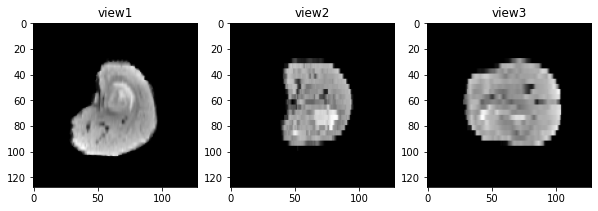

In [10]:
fig,a =  plt.subplots(1,3, figsize=(10,10))
a[0].imshow(gt_x[64,:],cmap='gray')
a[0].set_title('view1')
a[1].imshow(gt_x[:,64,:],cmap='gray')
a[1].set_title('view2')
a[2].imshow(gt_x[:,:,64],cmap='gray')
a[2].set_title('view3')

Text(0.5, 1.0, 'view3')

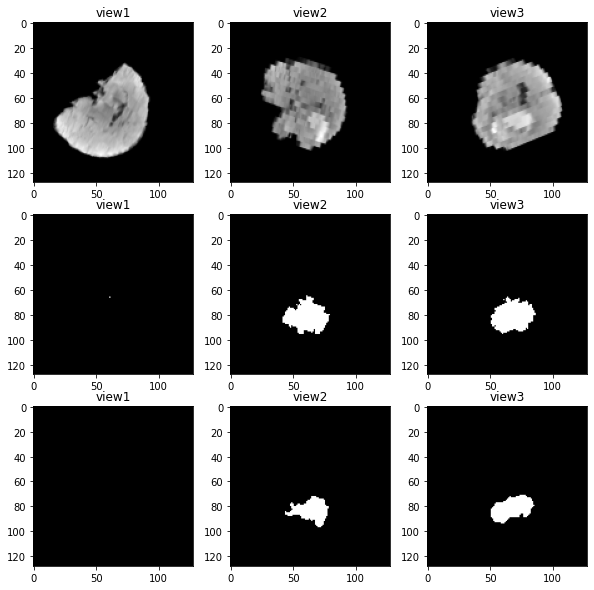

In [12]:
fig,a =  plt.subplots(3,3, figsize=(10,10))
a[0,0].imshow(image_x[64,:],cmap='gray')
a[0,0].set_title('view1')
a[0,1].imshow(image_x[:,64,:],cmap='gray')
a[0,1].set_title('view2')
a[0,2].imshow(image_x[:,:,64],cmap='gray')
a[0,2].set_title('view3')
a[1,0].imshow(low_mask_x[0,64,:]>0,cmap='gray')
a[1,0].set_title('view1')
a[1,1].imshow(low_mask_x[0,:,64,:]>0,cmap='gray')
a[1,1].set_title('view2')
a[1,2].imshow(low_mask_x[0,:,:,64]>0,cmap='gray')
a[1,2].set_title('view3')
a[2,0].imshow(pre_segA_x[64,:]>0.5,cmap='gray')
a[2,0].set_title('view1')
a[2,1].imshow(pre_segA_x[:,64,:]>0.5,cmap='gray')
a[2,1].set_title('view2')
a[2,2].imshow(pre_segA_x[:,:,64]>0.5,cmap='gray')
a[2,2].set_title('view3')

Text(0.5, 1.0, 'view3')

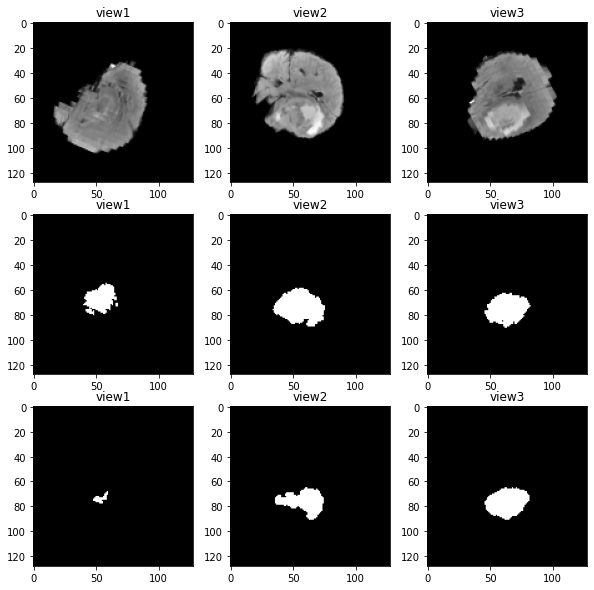

In [13]:
fig,a =  plt.subplots(3,3, figsize=(10,10))
a[0,0].imshow(image_y[64,:],cmap='gray')
a[0,0].set_title('view1')
a[0,1].imshow(image_y[:,64,:],cmap='gray')
a[0,1].set_title('view2')
a[0,2].imshow(image_y[:,:,64],cmap='gray')
a[0,2].set_title('view3')
a[1,0].imshow(low_mask_y[0,64,:]>0,cmap='gray')
a[1,0].set_title('view1')
a[1,1].imshow(low_mask_y[0,:,64,:]>0,cmap='gray')
a[1,1].set_title('view2')
a[1,2].imshow(low_mask_y[0,:,:,64]>0,cmap='gray')
a[1,2].set_title('view3')
a[2,0].imshow(pre_segA_y[64,:]>0.5,cmap='gray')
a[2,0].set_title('view1')
a[2,1].imshow(pre_segA_y[:,64,:]>0.5,cmap='gray')
a[2,1].set_title('view2')
a[2,2].imshow(pre_segA_y[:,:,64]>0.5,cmap='gray')
a[2,2].set_title('view3')

Text(0.5, 1.0, 'view3')

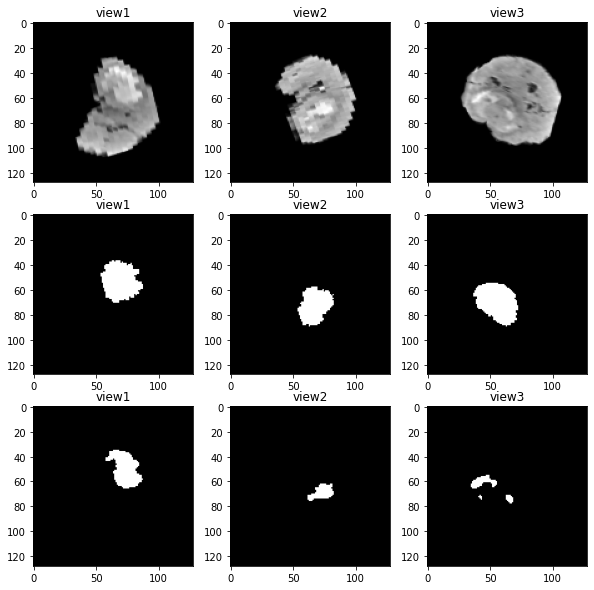

In [25]:
fig,a =  plt.subplots(3,3, figsize=(10,10))
a[0,0].imshow(image_z[64,:],cmap='gray')
a[0,0].set_title('view1')
a[0,1].imshow(image_z[:,64,:],cmap='gray')
a[0,1].set_title('view2')
a[0,2].imshow(image_z[:,:,64],cmap='gray')
a[0,2].set_title('view3')
a[1,0].imshow(low_mask_z[0,64,:]>0,cmap='gray')
a[1,0].set_title('view1')
a[1,1].imshow(low_mask_z[0,:,64,:]>0,cmap='gray')
a[1,1].set_title('view2')
a[1,2].imshow(low_mask_z[0,:,:,64]>0,cmap='gray')
a[1,2].set_title('view3')
a[2,0].imshow(pre_segA_z[64,:]>0.5,cmap='gray')
a[2,0].set_title('view1')
a[2,1].imshow(pre_segA_z[:,64,:]>0.5,cmap='gray')
a[2,1].set_title('view2')
a[2,2].imshow(pre_segA_z[:,:,64]>0.5,cmap='gray')
a[2,2].set_title('view3')

In [23]:
dataroot

('./evaluation_pairs_8/images/Brats18_TCIA03_199_1',)

In [29]:
low_dice_x_list = []
low_dice_y_list = []
low_dice_z_list = []
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    dataroot = './evaluation_pairs_8/images/' + case_name
    labelroot = './generated_pairs_8/images/' + case_name
    ####### Image Pre-processing ##############################################
    img_name = 'x.nii.gz'
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    image_x,gt_x,pre_segA_x,pre_segB_x = test_seg(dataFile,labelFile)
    eval_mask= nib.load(os.path.join('./evaluation_pairs_8/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_x = zoom(mask,(1,1/2,1/2,1/2),order=1)
    dice_low = dice(np.array(pre_segA_x)>0.5, np.array(low_mask_x[0])>0.1,nargout=1)
    low_dice_x_list.append(dice_low[0])
    print('dice for low resolution mask x')
    print(dice_low)


    img_name = 'y.nii.gz'
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    image_y,gt_y,pre_segA_y,pre_segB_y = test_seg(dataFile,labelFile)
    eval_mask= nib.load(os.path.join('./evaluation_pairs_8/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_y = zoom(mask,(1,1/2,1/2,1/2),order=1)
    dice_low = dice(np.array(pre_segA_y)>0.5, np.array(low_mask_y[0])>0.1,nargout=1)
    low_dice_y_list.append(dice_low[0])
    print('dice for low resolution mask y')
    print(dice_low)


    img_name = 'z.nii.gz'
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    image_z,gt_z,pre_segA_z,pre_segB_z = test_seg(dataFile,labelFile)
    eval_mask= nib.load(os.path.join('./evaluation_pairs_8/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_z = zoom(mask,(1,1/2,1/2,1/2),order=1)
    dice_low = dice(np.array(pre_segA_z)>0.5, np.array(low_mask_z[0])>0.1,nargout=1)
    low_dice_z_list.append(dice_low[0])
    print('dice for low resolution mask z')
    print(dice_low)
    save_folder = 'test_onlyseg_results_128'
    if not os.path.exists(os.path.join(save_folder,case_name)):
        os.mkdir(os.path.join(save_folder,case_name))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_x),0)).save(os.path.join(save_folder,case_name,'gt_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_y),0)).save(os.path.join(save_folder,case_name,'gt_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_z),0)).save(os.path.join(save_folder,case_name,'gt_z.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_x),0)).save(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_y),0)).save(os.path.join(save_folder,case_name,'pre_seg_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_z),0)).save(os.path.join(save_folder,case_name,'pre_seg_z.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_x),0)).save(os.path.join(save_folder,case_name,'image_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_y),0)).save(os.path.join(save_folder,case_name,'image_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_z),0)).save(os.path.join(save_folder,case_name,'image_z.nii.gz'))

test volume = ./evaluation_pairs_8/images/Brats18_TCIA03_199_1/x.nii.gz
dice for low resolution mask x
[0.85751081]
test volume = ./evaluation_pairs_8/images/Brats18_TCIA03_199_1/y.nii.gz
dice for low resolution mask y
[0.89540895]
test volume = ./evaluation_pairs_8/images/Brats18_TCIA03_199_1/z.nii.gz
dice for low resolution mask z
[0.88491037]
test volume = ./evaluation_pairs_8/images/Brats18_TCIA03_257_1/x.nii.gz
dice for low resolution mask x
[0.84072151]
test volume = ./evaluation_pairs_8/images/Brats18_TCIA03_257_1/y.nii.gz
dice for low resolution mask y
[0.83608348]
test volume = ./evaluation_pairs_8/images/Brats18_TCIA03_257_1/z.nii.gz
dice for low resolution mask z
[0.85840582]
test volume = ./evaluation_pairs_8/images/Brats18_TCIA03_265_1/x.nii.gz
dice for low resolution mask x
[0.89367121]
test volume = ./evaluation_pairs_8/images/Brats18_TCIA03_265_1/y.nii.gz
dice for low resolution mask y
[0.87986631]
test volume = ./evaluation_pairs_8/images/Brats18_TCIA03_265_1/z.nii.gz


In [12]:
np.array(low_dice_x_list).max()

NameError: name 'low_dice_x_list' is not defined

In [15]:
dice_overlap_list = []
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    dataroot = './generated_pairs_8/images/' + case_name
    labelroot = './generated_pairs_8/images/' + case_name
    ####### Image Pre-processing ##############################################
    dataFile= os.path.join(dataroot, 'y.nii.gz')
    labelFile = os.path.join(labelroot, 'z.nii.gz')
    image_x,gt_x,pre_segA_x,pre_segB_x = test_seg(dataFile,labelFile)
    dice_overlap = dice(np.array(pre_segA_x)>0.5, np.array(pre_segB_x)>0.5,nargout=1)
    dice_overlap_list.append(dice_overlap[0])
    print('dice for overlap x and y')
    print(dice_overlap[0])

test volume = ./generated_pairs_8/images/Brats18_TCIA03_199_1/y.nii.gz
dice for overlap x and y
0.8813279719558718
test volume = ./generated_pairs_8/images/Brats18_TCIA03_257_1/y.nii.gz
dice for overlap x and y
0.8934366745043397
test volume = ./generated_pairs_8/images/Brats18_TCIA03_265_1/y.nii.gz
dice for overlap x and y
0.8713420418886375
test volume = ./generated_pairs_8/images/Brats18_TCIA03_296_1/y.nii.gz
dice for overlap x and y
0.9023882113821138
test volume = ./generated_pairs_8/images/Brats18_TCIA03_338_1/y.nii.gz
dice for overlap x and y
0.8100909357582868
test volume = ./generated_pairs_8/images/Brats18_TCIA03_375_1/y.nii.gz
dice for overlap x and y
0.8718853820598007
test volume = ./generated_pairs_8/images/Brats18_TCIA03_419_1/y.nii.gz
dice for overlap x and y
0.883958228150825
test volume = ./generated_pairs_8/images/Brats18_TCIA03_474_1/y.nii.gz
dice for overlap x and y
0.8714102358414888
test volume = ./generated_pairs_8/images/Brats18_TCIA04_111_1/y.nii.gz
dice for o

In [16]:
np.array(dice_overlap_list).mean()

0.8780781468754506

In [16]:
transform = tio.CropOrPad(
    (256, 256, 256),
)
img= tio.ScalarImage(os.path.join('./gt_pairs/images',case_name,'x.nii.gz'))
gt_x = np.array(torch.squeeze(transform(img).data))
img= tio.ScalarImage(os.path.join('./gt_pairs/images',case_name,'y.nii.gz'))
gt_y = np.array(torch.squeeze(transform(img).data))
img = tio.ScalarImage(os.path.join('./gt_pairs/images',case_name,'z.nii.gz'))
gt_z = np.array(torch.squeeze(transform(img).data))

In [17]:
def drawContour(m,s,c,RGB):
    """Draw edges of contour 'c' from segmented image 's' onto 'm' in colour 'RGB'"""
    # Fill contour "c" with white, make all else black
    thisContour = s.point(lambda p:p==c and 255)
    # DEBUG: thisContour.save(f"interim{c}.png")

    # Find edges of this contour and make into Numpy array
    thisEdges   = thisContour.filter(ImageFilter.FIND_EDGES)
    thisEdgesN  = np.array(thisEdges)

    # Paint locations of found edges in color "RGB" onto "main"
    m[np.nonzero(thisEdgesN)] = RGB
    return m

In [18]:
filter_size = 5
x = gaussian_filter(filter_size)
prob_x = np.zeros(obj_x.data.shape)
for i in range(obj_x.data.shape[2]):
    for j in range(obj_x.data.shape[3]):
        prob_x[0,:,i,j] = np.convolve(x,np.array(gt_x[:,i,j]>0.5,dtype=float))[filter_size:-filter_size]
prob_y = np.zeros(obj_y.data.shape)
for i in range(obj_y.data.shape[1]):
    for j in range(obj_y.data.shape[3]):
        prob_y[0,i,:,j] = np.convolve(x,np.array(gt_y[i,:,j]>0.5,dtype=float))[filter_size:-filter_size]
prob_z = np.zeros(obj_z.data.shape)
for i in range(obj_z.data.shape[1]):
    for j in range(obj_z.data.shape[2]):
        prob_z[0,i,j,:] = np.convolve(x,np.array(gt_z[i,j,:]>0.5,dtype=float))[filter_size:-filter_size]

In [19]:
final_image = np.zeros(prob_x.size)
prob_x_flatten = prob_x.flatten()
prob_y_flatten = prob_y.flatten()
prob_z_flatten = prob_z.flatten()
map_x_flatten = obj_x.flatten()
map_y_flatten = obj_y.flatten()
map_z_flatten = obj_z.flatten()
for idx in range(prob_x_flatten.size):
    if prob_x_flatten[idx]+prob_y_flatten[idx]+prob_z_flatten[idx]>0.4:
        ratio = (prob_x_flatten[idx]+prob_y_flatten[idx]+prob_z_flatten[idx])
        prob_x_flatten[idx], prob_y_flatten[idx], prob_z_flatten[idx] = \
        prob_x_flatten[idx]/ratio ,prob_y_flatten[idx]/ratio,prob_z_flatten[idx]/ratio 
        final_image[idx] = prob_x_flatten[idx]*map_x_flatten[idx]+prob_y_flatten[idx]*map_y_flatten[idx]+prob_z_flatten[idx]*map_z_flatten[idx]
final_image = np.clip(np.round(final_image*1),0,a_max=1).reshape(prob_x.shape)
#zoom_final_image = zoom(final_image,(1,1/4,1/4,1/4))

In [20]:
transform = tio.CropOrPad(
    (256, 256, 256),
)
high_reso_image = transform(tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_flair.nii.gz'))).data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


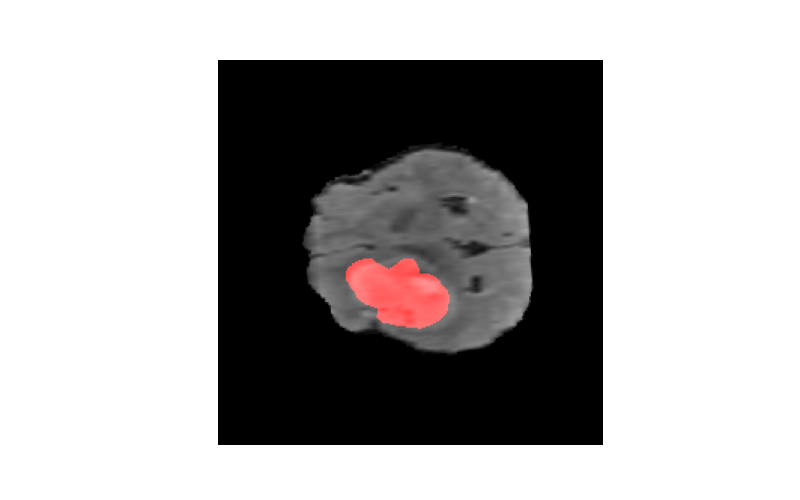

In [45]:
from skimage import io, color
slice = 120
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(zoom(regist_mask_z,(4,4,4),order=1))[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


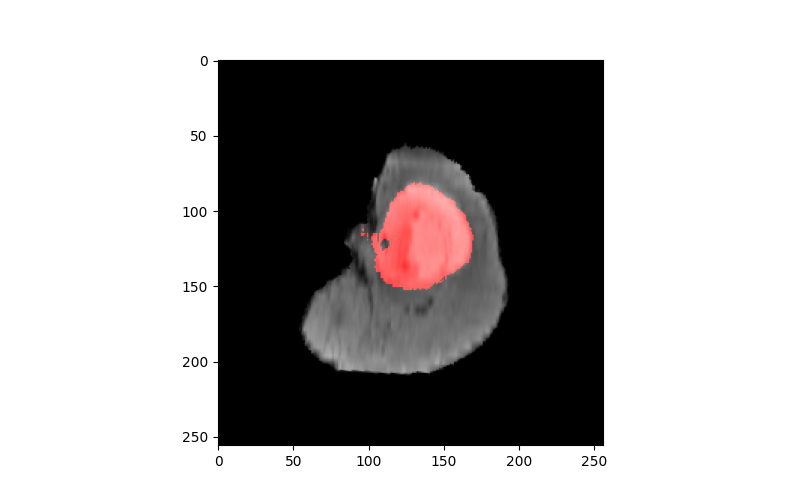

In [43]:
from skimage import io, color
plt.figure(figsize=(8,5))
slice = 120
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(high_mask[0,145]>0.5),image_show[0,142],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


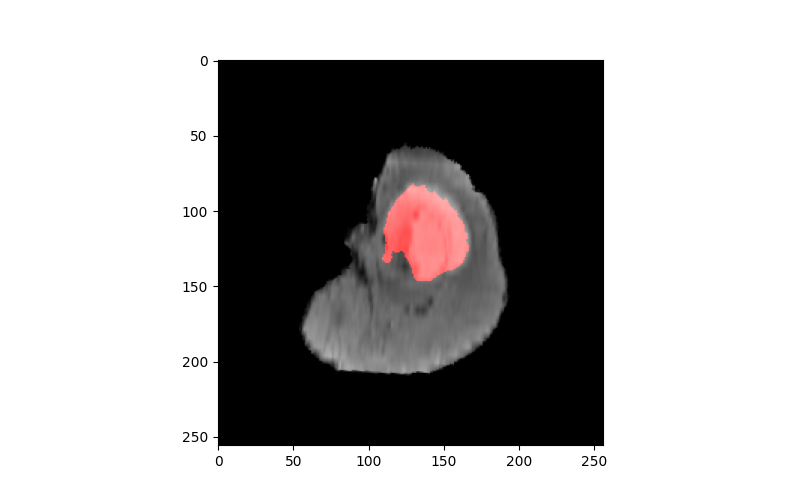

In [39]:
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(final_image[0,142]>0.5),image_show[0,142],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.show()

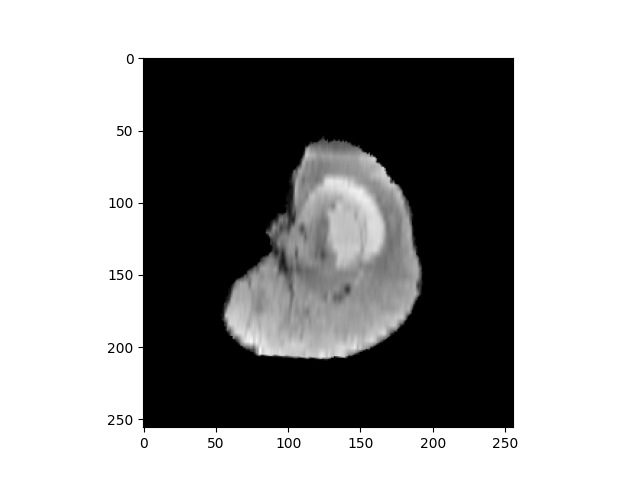

In [23]:
plt.figure()
plt.imshow(high_reso_image[0,141,:,:],cmap='gray')

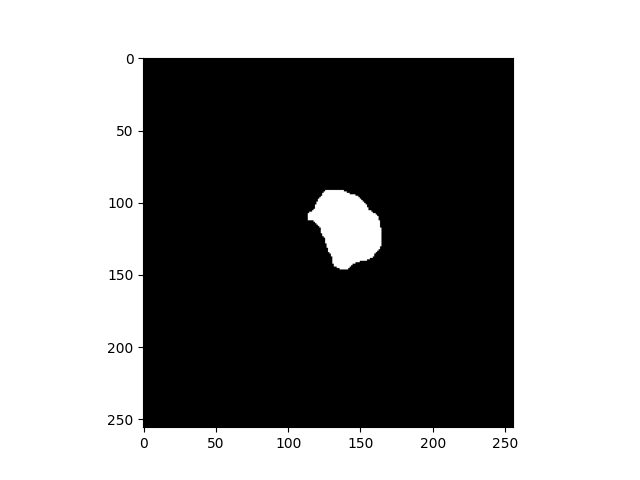

In [24]:
plt.figure()
plt.imshow(obj_x[0,141,:,:]>0.5,cmap='gray')

In [25]:
print('dice for high resolution mask')
print(dice(np.array(final_image[0]), np.array(high_mask[0])>0.1,nargout=1))

dice for high resolution mask
[0.89499338]


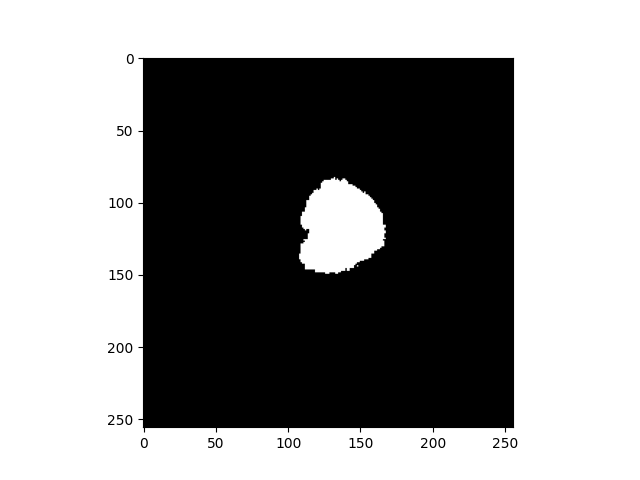

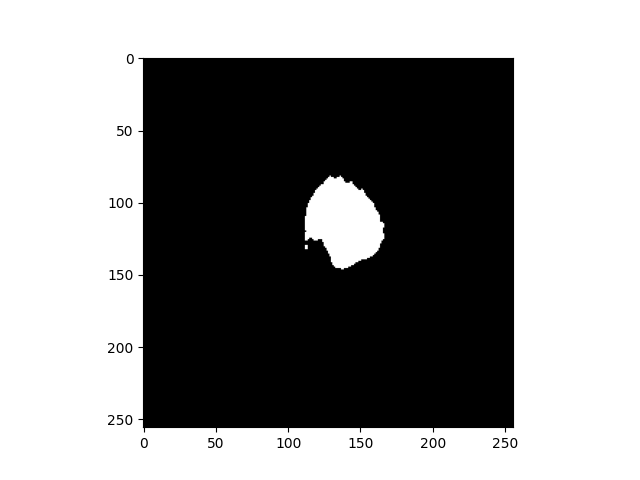

In [99]:
plt.figure()
plt.imshow(final_image[0,141,:,:]>0.5,cmap='gray')

In [ ]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# points is a 3D numpy array (n_points, 3) coordinates of a sphere

verts, faces, norm, val = measure.marching_cubes(np.array(final_image[0]>0), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
face_color = ['r']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

verts, faces, norm, val = measure.marching_cubes(np.array(gt_seg[0]>0), allow_degenerate=True)

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
#mesh.set_facecolor('r')
#mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

plt.tight_layout()
plt.show()

In [68]:
regist_mask_x_final = np.array(regist_mask_x>0.5,dtype=int)
regist_mask_y_final = np.array(regist_mask_y>0.5,dtype=int)
regist_mask_z_final = np.array(regist_mask_z>0.5,dtype=int)

In [69]:
fusion_mask = np.array((regist_mask_x_final + regist_mask_y_final + regist_mask_z_final)>2,dtype=int)

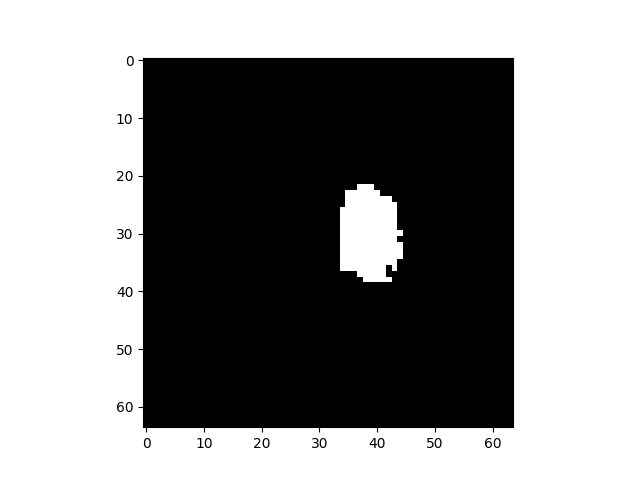

In [70]:
plt.figure()
plt.imshow(fusion_mask[35,:,:]>0.1,cmap='gray')

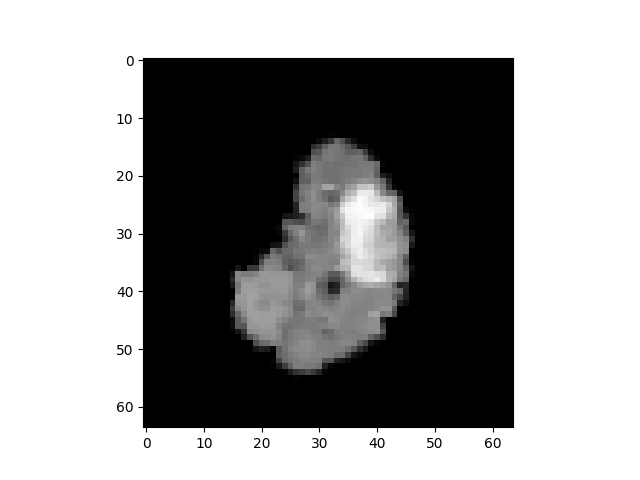

In [71]:
plt.figure()
plt.imshow(aligned_img_z[35,:,:],cmap='gray')

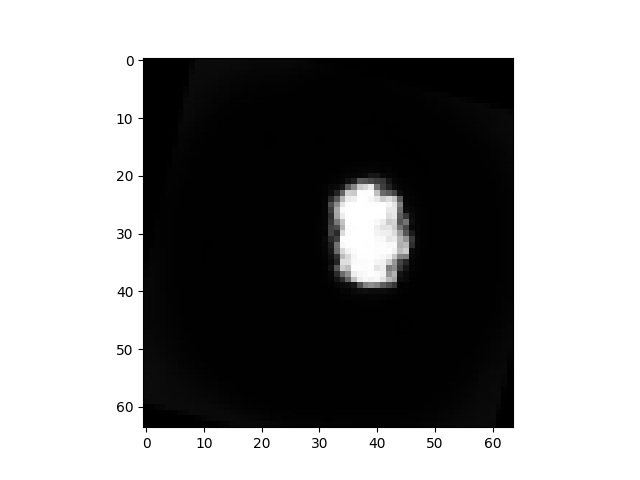

In [72]:
plt.figure()
plt.imshow(regist_mask_z[35,:,:],cmap='gray')

In [73]:
print('dice for high resolution mask z')
print(dice(np.array(fusion_mask)>0.5, np.array(high_mask[0])>0.1,nargout=1))

dice for high resolution mask z
[0.87513894]


In [268]:
point_x,point_y,point_z = np.where(label_vol>0)
X_fix = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
point_x,point_y,point_z = np.where(origin_data>0)
X_mov = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
X_fix = X_fix[::10]
X_mov = X_mov[::10]
ax.scatter(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.5,c='r')
ax.scatter(X_mov[:,0],X_mov[:,1],X_mov[:,2],alpha=0.5,c='b')
ax.set_box_aspect([1,1,1])

(1, 240, 240, 240)

In [356]:
dice(final_image>0, np.array(gt_seg)>0,nargout=1)

array([0.95101183])

In [371]:
dice(np.array(final_image,dtype=int), np.array(gt_seg),nargout=1)

array([0.60195159, 0.66104925, 0.        , 0.40467395])

In [378]:
np.sum(np.array(gt_x)==3)

0

In [382]:
dice(np.array(mask_z)>0, np.array(gt_seg)>0,nargout=1)

array([0.94489615])

In [ ]:
plt.figure()
plt.imshow(gt_seg[0,:,:,70],cmap='gray')

In [ ]:
plt.figure()
plt.imshow(obj_final[0,:,:,70],cmap='gray')

In [ ]:
plt.figure()
plt.imshow(gt_x[100,:,:]>0,cmap='gray')

In [346]:
## compare with gt
resample = tio.Resample((5,1,1),image_interpolation='nearest')
resampled_mask_x = resample(mask)
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask_x = resample(resampled_mask_x).data
resample = tio.Resample((1,5,1),image_interpolation='nearest')
resampled_mask_y = resample(mask)
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask_y = resample(resampled_mask_y).data
resample = tio.Resample((1,1,5),image_interpolation='nearest')
resampled_mask_z = resample(mask)
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask_z = resample(resampled_mask_z).data

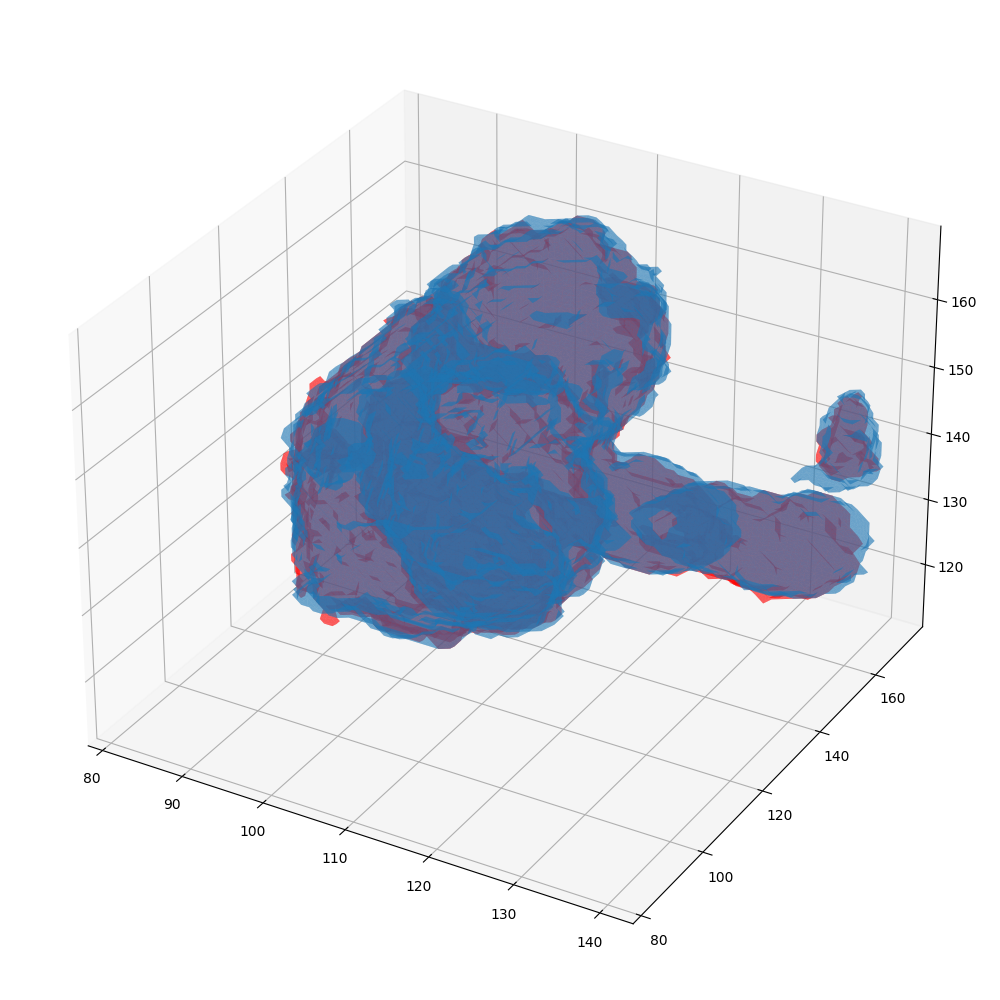

In [86]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# points is a 3D numpy array (n_points, 3) coordinates of a sphere

verts, faces, norm, val = measure.marching_cubes(np.array(final_image[0]>0), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
face_color = ['r']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

verts, faces, norm, val = measure.marching_cubes(np.array(gt_seg[0]>0), allow_degenerate=True)

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
#mesh.set_facecolor('r')
#mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

plt.tight_layout()
plt.show()

In [21]:
obj_z.shape

torch.Size([1, 1, 240, 240, 240])

In [213]:
point_x,point_y,point_z = np.where(obj_z[0][0]>0)
X_fix = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
point_x,point_y,point_z = np.where(gt_seg[0]>0)
X_mov = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
X_fix = X_fix[::10] - 32
X_mov = X_mov[::10] - 32
ax.scatter(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.2,c='r')
#ax.plot_surface(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.5,c='r')
ax.scatter(X_mov[:,0],X_mov[:,1],X_mov[:,2],alpha=0.2,c='b')
ax.set_box_aspect([1,1,1])

ValueError: not enough values to unpack (expected 3, got 2)

In [16]:
img= nib.load('./generated_pairs_8/images/Brats18_2013_2_1/x.nii.gz')
gt_x = np.array(img.dataobj)
img= nib.load('./generated_pairs_8/images/Brats18_2013_2_1/y.nii.gz')
gt_y = np.array(img.dataobj)
img= nib.load('./generated_pairs_8/images/Brats18_2013_2_1/z.nii.gz')
gt_z = np.array(img.dataobj)

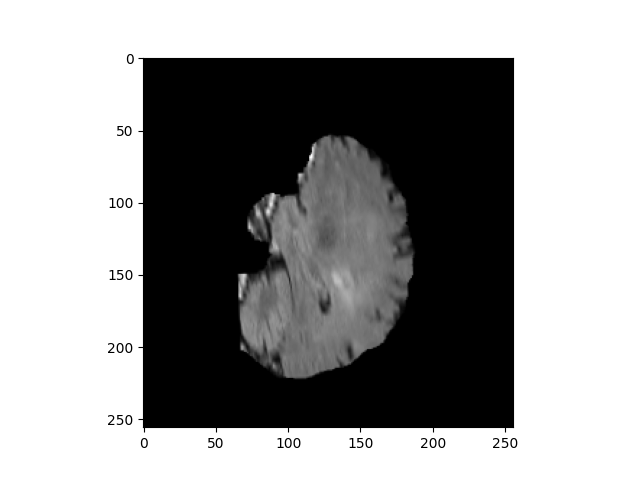

In [18]:
plt.figure()
plt.imshow(gt_x[100,:,:],cmap='gray')

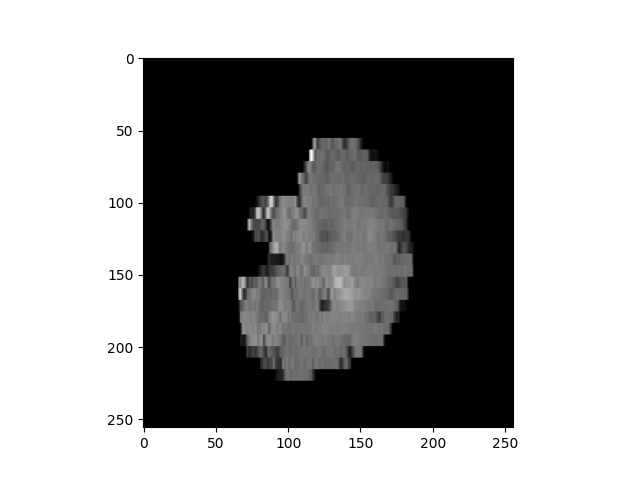

In [19]:
plt.figure()
plt.imshow(gt_y[100,:,:],cmap='gray')

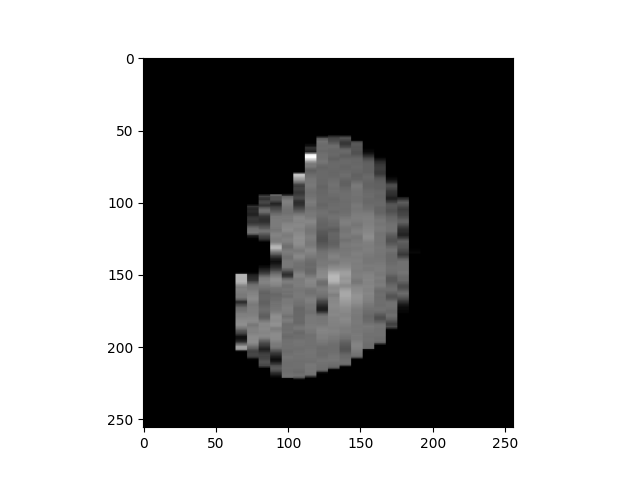

In [20]:
plt.figure()
plt.imshow(gt_z[100,:,:],cmap='gray')

## use traditional methods to align

In [ ]:
image_x
gt_x

In [164]:
gt_x.shape

(64, 64, 64)

In [173]:
from pycpd import RigidRegistration

In [256]:
spacing = [[1,0,0],[0,1,0],[0,0,1]]
point_x,point_y,point_z = np.where(gt_x>0)
X_fix = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing) 
point_x,point_y,point_z = np.where(image_x>0)
X_mov = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
X_fix_resample = X_fix[::5]
X_mov_resample = X_mov[::5] 
X_fix_resample = X_fix_resample -32.0
X_mov_resample = X_mov_resample -32.0

In [257]:
reg = RigidRegistration(X=X_fix_resample,Y=X_mov_resample)
# reg = rigid_registration(**{'X': X, 'Y': Y, 'scale': False})
# The above shows an example where we dont "test" or determine the scale.
# This makes it clear the CPD first actually shrinks the mesh and then "grows" it iteratively to make it
# best fit the data.
TY, (s_reg, R_reg, t_reg) = reg.register()

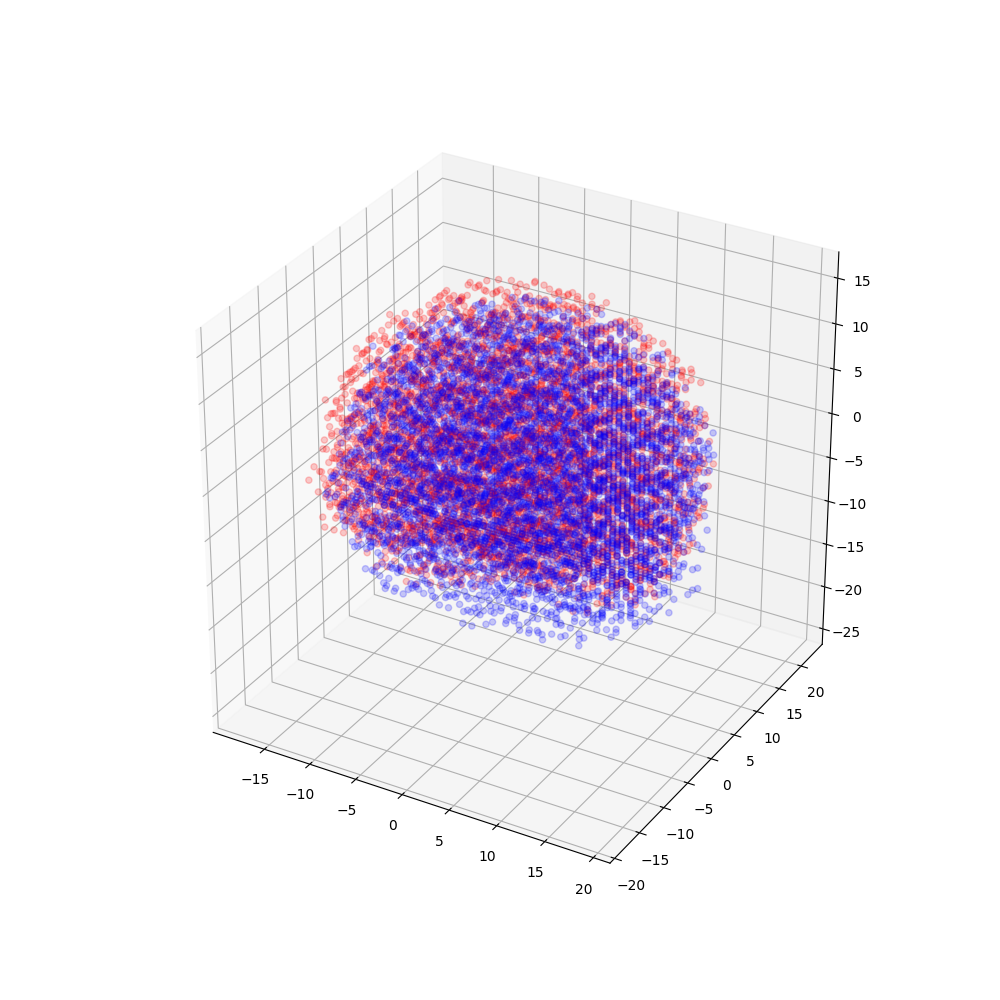

In [258]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_fix_resample[:,0],X_fix_resample[:,1],X_fix_resample[:,2],alpha=0.2,c='r')
#ax.plot_surface(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.5,c='r')
ax.scatter(X_mov_resample[:,0],X_mov_resample[:,1],X_mov_resample[:,2],alpha=0.2,c='b')
ax.set_box_aspect([1,1,1])

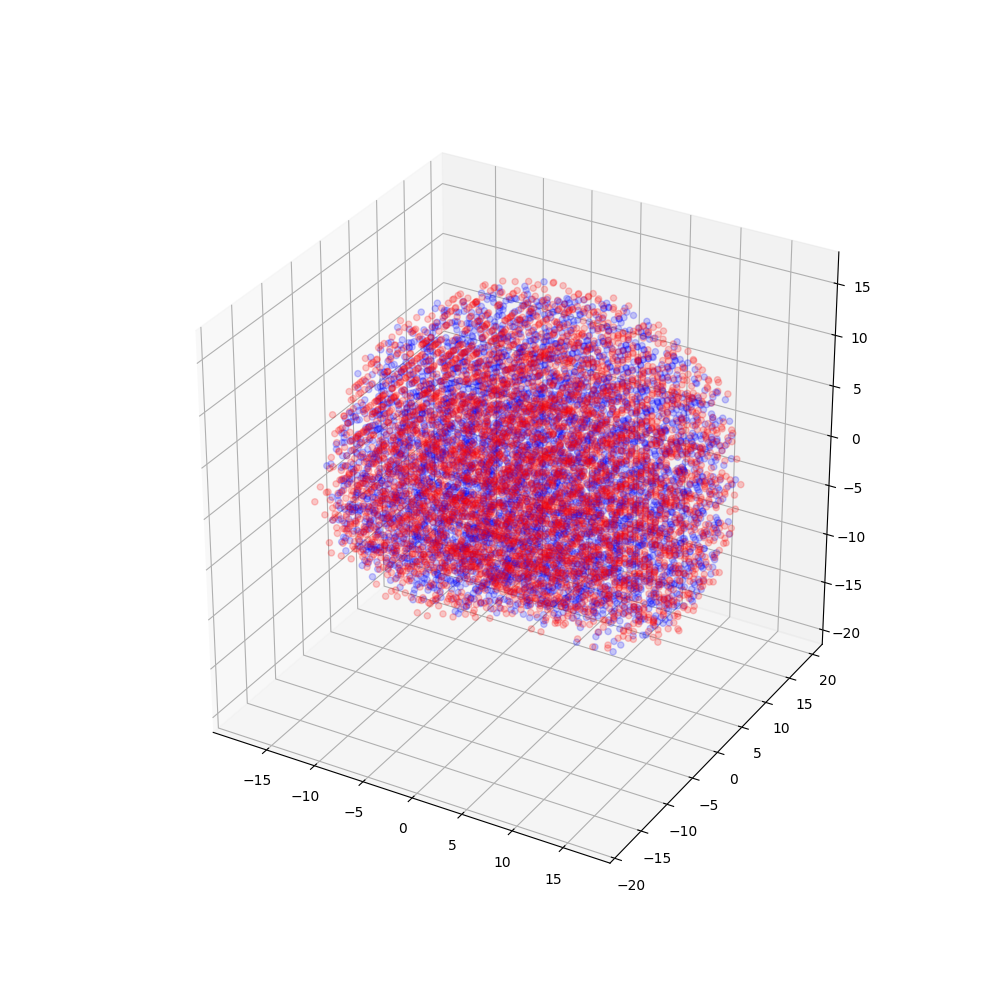

In [259]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_fix_resample[:,0],X_fix_resample[:,1],X_fix_resample[:,2],alpha=0.2,c='r')
#ax.plot_surface(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.5,c='r')
ax.scatter(TY[:,0],TY[:,1],TY[:,2],alpha=0.2,c='b')
ax.set_box_aspect([1,1,1])

In [260]:
def rot2eul(R):
    beta = -np.arcsin(R[2,0])
    alpha = np.arctan2(R[2,1]/np.cos(beta),R[2,2]/np.cos(beta))
    gamma = np.arctan2(R[1,0]/np.cos(beta),R[0,0]/np.cos(beta))
    return alpha, beta, gamma

In [261]:
theta_x,theta_y,theta_z = rot2eul(R_reg)

In [268]:
theta_x,theta_y,theta_z

(-0.333843681602335, 0.25267657206546074, 0.36414763539484746)

In [270]:
t_reg

array([-2.86846326, -1.1948931 ,  0.2610444 ])

In [271]:
from monai.transforms import Affine
# create an Affine transform
affine = Affine(
    scale_params = float(s_reg),
    rotate_params=(theta_x,theta_y,theta_z),
    translate_params=(-t_reg[0],-t_reg[1],-t_reg[2]),
    padding_mode="zeros",
)
align_pre_segA_x,_ = affine(pre_segA_x,mode='bilinear')

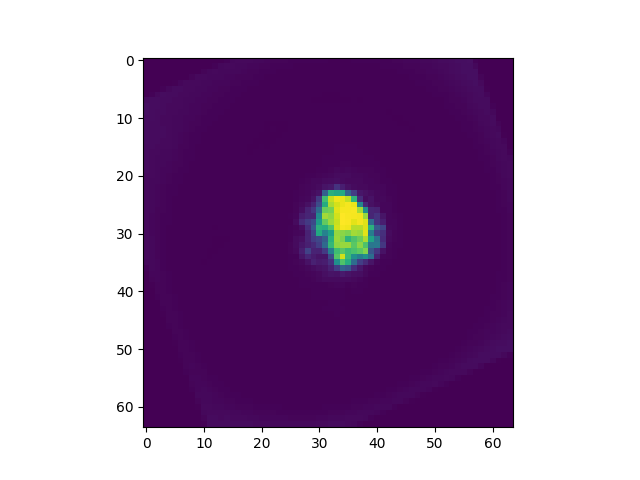

In [272]:
plt.figure()
plt.imshow(regist_mask_x[34])

In [277]:
print('dice for low resolution mask x')
print(dice(np.array(align_pre_segA_x)>0.5, np.array(low_mask_x[0])>0.1,nargout=1))
print('dice for high resolution mask x')
print(dice(np.array(zoom(align_pre_segA_x,(4,4,4),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1))

dice for low resolution mask x
[0.71870794]
dice for high resolution mask x
[0.56699657]


In [ ]:
dice for high resolution mask x
[0.86190031]